In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, applications
from tensorflow.keras import mixed_precision

In [2]:

# GPU Memory Management
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e: print(e)

In [3]:
# RTX 3090 ke liye Mixed Precision On karen
mixed_precision.set_global_policy('float32') 
print("✅ Policy reset to float32 (Stability Mode)")

✅ Policy reset to float32 (Stability Mode)


In [4]:
DATA_DIR = r"C:\Users\Sky hawk\Downloads\huzaifa\archive_2\dataset_split"
IMG_SIZE = 512
BATCH_SIZE = 64 

def make_dataset(subset):
    ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(DATA_DIR, subset),
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        label_mode='int'
    )
    
    names = ds.class_names
    
    # .cache() hata diya taake 32GB RAM crash na ho
    # NVMe ki speed par bharosa rakhen
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return ds, names

# Datasets aur class names load karen
train_ds, train_class_names = make_dataset('train')
val_ds, val_class_names = make_dataset('val')

class_names = train_class_names
NUM_CLASSES = len(class_names)


from sklearn.utils import class_weight
import numpy as np

# 1. Training dataset se labels nikal kar weights calculate karen
print("⏳ Calculating class weights...")
labels = np.concatenate([y for x, y in train_ds], axis=0)
weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weight_dict = dict(enumerate(weights))

print(f"✅ Class Weights calculated: {class_weight_dict}")
print(f"✅ Found {NUM_CLASSES} classes: {class_names}")
print("🚀 Turbo Pipeline Ready for NVMe!")

Found 53376 files belonging to 5 classes.
Found 1965 files belonging to 5 classes.
⏳ Calculating class weights...
✅ Class Weights calculated: {0: 1.41656050955414, 1: 1.0615751789976133, 2: 0.8057971014492754, 3: 0.8659312134977287, 4: 1.0457680250783699}
✅ Found 5 classes: ['Atopic Dermatitis', 'Eczema', 'Melanoma', 'Psoriasis', 'Ringworm']
🚀 Turbo Pipeline Ready for NVMe!


In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models

# ConvNeXt-Base ko dobara load karna (Transfer Learning ke liye)
print("⏳ Loading ConvNeXt-Base... (Wait a moment)")
base_model = tf.keras.applications.ConvNeXtBase(
    model_name='convnext_base',
    include_top=False,
    include_preprocessing=True, # ConvNeXt built-in preprocessing use karta hai
    weights='imagenet',
    input_shape=(512, 512, 3)
)

# Base model ko freeze rakhna taake purani learning kharab na ho
base_model.trainable = False
print("✅ Base Model is ready!")

⏳ Loading ConvNeXt-Base... (Wait a moment)
✅ Base Model is ready!


In [11]:

# 1. Augmentation Layer: Images ko randomly rotate/flip karega
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# 2. Model Building
inputs = layers.Input(shape=(512, 512, 3))
x = data_augmentation(inputs)  # Pehle images augment hongi
x = base_model(x, training=False) # Base model (ConvNeXt) frozen rahega
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)     # Dropout 0.3 se 0.5 kar diya (Overfitting fix)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = models.Model(inputs, outputs)

# 3. Compilation: Slow learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5), 
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary(line_length=150)

Model: "model_1"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                                      Output Shape                                                Param #                
 input_7 (InputLayer)                                              [(None, 512, 512, 3)]                                       0                      
                                                                                                                                                      
 sequential_5 (Sequential)                                         (None, 512, 512, 3)                                         0                      
                                                                                                                                                      
 convnext_base (Functional)                                        (None, 16,

In [12]:
# 1. Early Stopping: Agar model seekhna band kar de toh training rok dega
# 2. ModelCheckpoint: Sirf sabse best accuracy wala model save karega
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=3, 
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_convnext_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print(f"\n🚀 Training Starting on RTX 3090...")
print(f"Target: 5 Classes | Image Size: {IMG_SIZE}x{IMG_SIZE}")

# model.fit automatically loss, accuracy, val_loss, aur val_accuracy dikhata hai
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=7, 
    class_weight=class_weight_dict, # Ye "Melanoma Bias" ko khatam karega
    callbacks=callbacks
)


🚀 Training Starting on RTX 3090...
Target: 5 Classes | Image Size: 512x512
Epoch 1/7
834/834 [==============================] - ETA: 0s - loss: 1.3046 - accuracy: 0.4651
Epoch 1: val_accuracy improved from -inf to 0.62341, saving model to best_convnext_model.h5
834/834 [==============================] - 1313s 2s/step - loss: 1.3046 - accuracy: 0.4651 - val_loss: 0.8860 - val_accuracy: 0.6234
Epoch 2/7
834/834 [==============================] - ETA: 0s - loss: 1.0223 - accuracy: 0.5841
Epoch 2: val_accuracy improved from 0.62341 to 0.65852, saving model to best_convnext_model.h5
834/834 [==============================] - 1299s 2s/step - loss: 1.0223 - accuracy: 0.5841 - val_loss: 0.7998 - val_accuracy: 0.6585
Epoch 3/7
834/834 [==============================] - ETA: 0s - loss: 0.9400 - accuracy: 0.6229
Epoch 3: val_accuracy improved from 0.65852 to 0.68041, saving model to best_convnext_model.h5
834/834 [==============================] - 1298s 2s/step - loss: 0.9400 - accuracy: 0.6229 

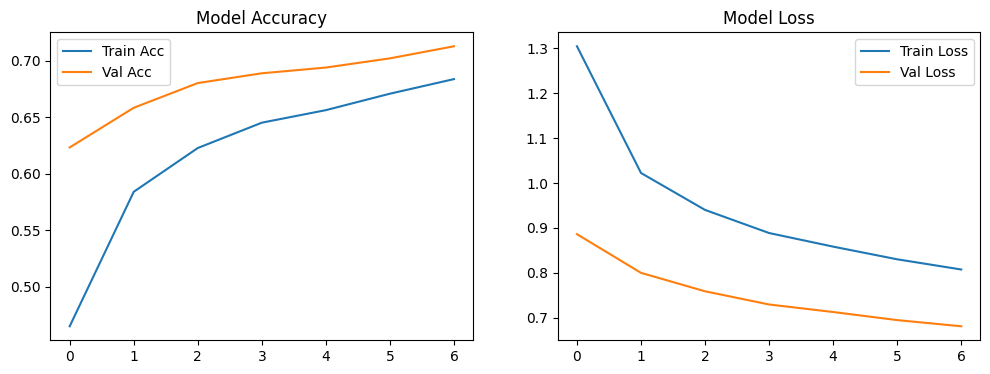

In [13]:
# Cell 5: Plot Results
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

✅ Weights successfully loaded into the model!
⏳ Generating predictions for validation set... (Is mein thora time lag sakta hai)
31/31 [==============================] - 39s 1s/step


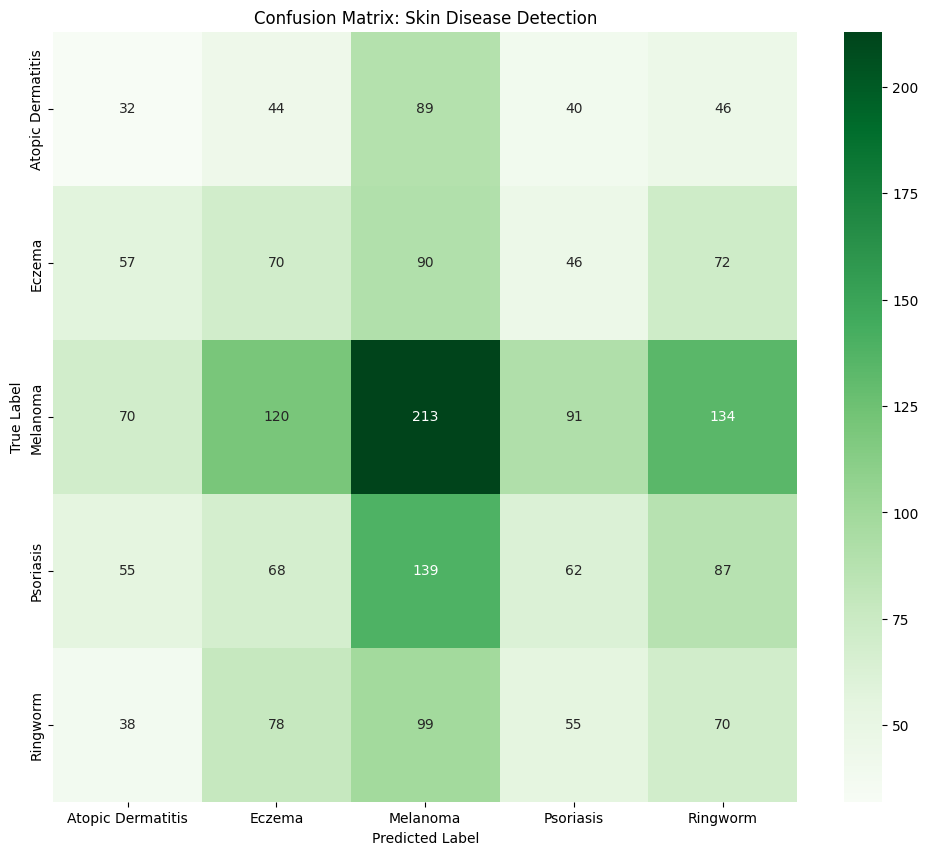


📝 Detailed Classification Report:

                   precision    recall  f1-score   support

Atopic Dermatitis       0.13      0.13      0.13       251
           Eczema       0.18      0.21      0.20       335
         Melanoma       0.34      0.34      0.34       628
        Psoriasis       0.21      0.15      0.18       411
         Ringworm       0.17      0.21      0.19       340

         accuracy                           0.23      1965
        macro avg       0.21      0.21      0.20      1965
     weighted avg       0.23      0.23      0.23      1965



In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Weights load karne ka sahi tareeqa
# Model wahi use hoga jo aapne pehle define kiya tha
model.load_weights(r'C:\Users\Sky hawk\Downloads\huzaifa\archive_2\best_convnext_model.h5')
print("✅ Weights successfully loaded into the model!")

# 2. Validation data par predictions len
print("⏳ Generating predictions for validation set... (Is mein thora time lag sakta hai)")
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. True labels nikalen (Validation set se asal labels nikalne ke liye)
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# 4. Confusion Matrix plot karen
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Skin Disease Detection')
plt.show()

# 5. Final Report
print("\n📝 Detailed Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 [==============================] - 0s 259ms/step

🔍 --- TOP 2 DIAGNOSIS --- 🔍
1. Ringworm: 28.12%
2. Psoriasis: 20.01%


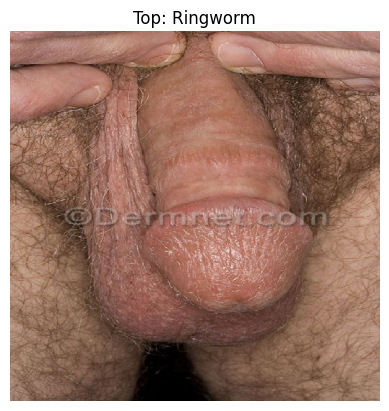

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# 1. Image path (Wahi image jo aapne pehle di thi)
img_path = r"C:\Users\Sky hawk\Downloads\huzaifa\archive_2\dataset_split\test\Melanoma\ISIC_6763469.jpg"

# 2. Image load aur preprocess
img = image.load_img(img_path, target_size=(512, 512))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# 3. Model Prediction
preds = model.predict(img_array)
# Softmax apply kar rahe hain taake probabilities 0-100% ke darmiyan aayein
score = tf.nn.softmax(preds[0]).numpy()

# 4. Top 2 Indices nikalna
# argsort index deta hai smallest se largest, is liye hum [::-1] use karke reverse kar rahe hain
top_2_indices = np.argsort(score)[::-1][:2]

print("\n🔍 --- TOP 2 DIAGNOSIS --- 🔍")
for i, idx in enumerate(top_2_indices):
    label = class_names[idx]
    confidence = score[idx] * 100
    print(f"{i+1}. {label}: {confidence:.2f}%")

# 5. Image display
plt.imshow(img)
plt.title(f"Top: {class_names[top_2_indices[0]]}")
plt.axis('off')
plt.show()